In [1]:
import pandas as pd
import numpy as np
import pymysql
import getpass
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_rows", 500)
%matplotlib inline
sns.set()
sns.set_style("whitegrid")

In [2]:
pw = getpass.getpass()

········


In [3]:
conn = pymysql.connect(host="localhost",
                       port=3306,
                       user="ironhack",
                       passwd=pw,
                       db="olist");

In [10]:
daily_orders_query = """
SELECT
    DATE(order_purchase_timestamp)  AS date_id,
    COUNT(*)                        AS no_of_orders
FROM orders
WHERE order_purchase_timestamp >= '2017-01-11'
    AND order_purchase_timestamp < '2018-08-23'
GROUP BY 1
ORDER BY 1;
"""

daily_orders = pd.read_sql(daily_orders_query, conn)

In [11]:
daily_orders.head()

,date_id,no_of_orders
0,2017-01-11,12
1,2017-01-12,13
2,2017-01-13,12
3,2017-01-14,18
4,2017-01-15,14


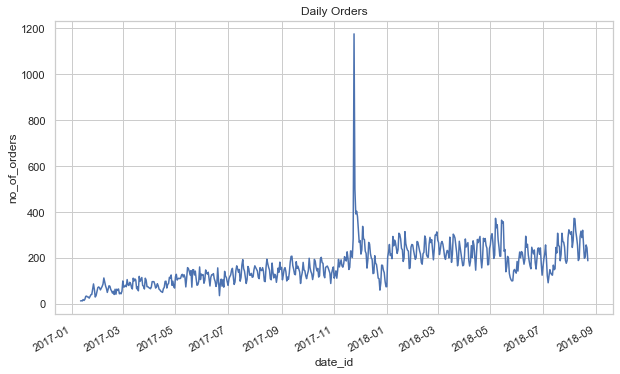

In [12]:
fig, ax = plt.subplots(figsize=(10,6))

sns.lineplot(data=daily_orders,
             x="date_id",
             y="no_of_orders",
             ax=ax);

ax.set_title("Daily Orders");

# automatically fits the xticks
fig.autofmt_xdate()

Zoom in to THE SPIKE

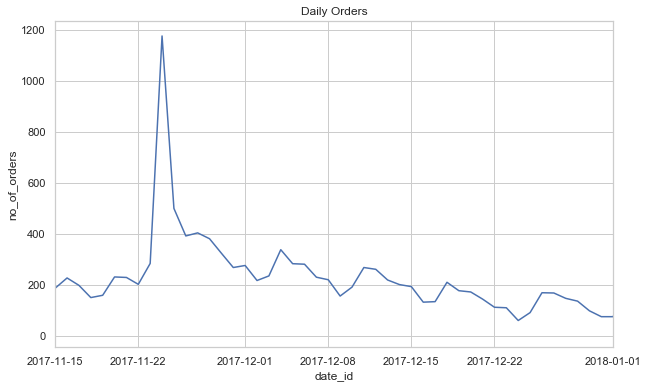

In [15]:
fig, ax = plt.subplots(figsize=(10,6))

sns.lineplot(data=daily_orders,
             x="date_id",
             y="no_of_orders",
             ax=ax);

ax.set_title("Daily Orders");
ax.set_xlim(("2017-11-15","2018-01-01"));

In [20]:
daily_orders[(daily_orders["date_id"] >= pd.to_datetime("2017-11-20")) & (daily_orders["date_id"] < pd.to_datetime("2017-11-30"))]

,date_id,no_of_orders
313,2017-11-20,230
314,2017-11-21,228
315,2017-11-22,201
316,2017-11-23,283
317,2017-11-24,1176
318,2017-11-25,499
319,2017-11-26,391
320,2017-11-27,403
321,2017-11-28,380
322,2017-11-29,323


Black Friday!

### Convert data to monthly data

In [23]:
daily_orders.dtypes

date_id         object
no_of_orders     int64
dtype: object

In [27]:
daily_orders["date_id"] = pd.to_datetime(daily_orders["date_id"])

In [28]:
daily_orders.dtypes

date_id         datetime64[ns]
no_of_orders             int64
dtype: object

In [34]:
monthly_orders = daily_orders.copy()

In [37]:
monthly_orders = monthly_orders.assign(month_id=monthly_orders["date_id"].dt.to_period("M"))

In [42]:
monthly_orders = (monthly_orders
                  .groupby("month_id")
                  .sum()
                  .reset_index())

In [44]:
monthly_orders.dtypes

month_id        period[M]
no_of_orders        int64
dtype: object

In [60]:
monthly_orders["month_id"] = pd.to_datetime(monthly_orders["month_id"].astype(str))

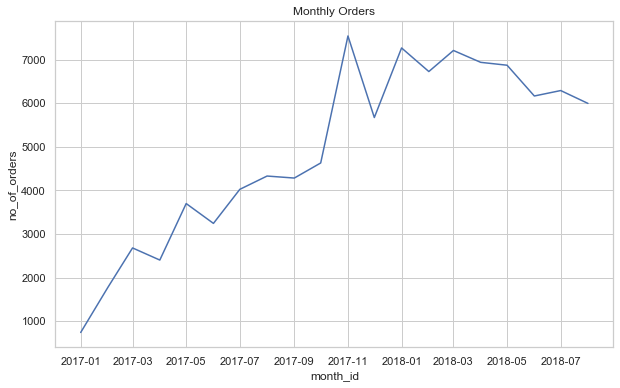

In [61]:
fig, ax = plt.subplots(figsize=(10,6))

sns.lineplot(data=monthly_orders,
             x="month_id",
             y="no_of_orders",
             ax=ax);

ax.set_title("Monthly Orders");

In [65]:
monthly_orders = (monthly_orders
                  .assign(year=monthly_orders["month_id"].dt.year)
                  .assign(month=monthly_orders["month_id"].dt.month))

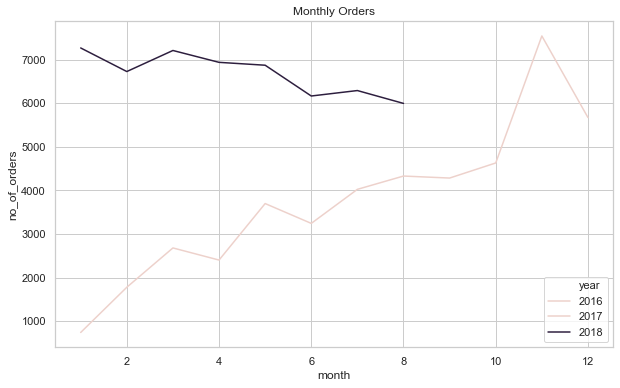

In [68]:
fig, ax = plt.subplots(figsize=(10,6))

sns.lineplot(data=monthly_orders,
             x="month",
             y="no_of_orders",
             hue="year",
             ax=ax);

ax.set_title("Monthly Orders");

Looking at other metrics

In [69]:
monthly_data_query = """
SELECT
    YEAR(o.order_purchase_timestamp)    AS year,
    MONTH(o.order_purchase_timestamp)   AS month,
    COUNT(DISTINCT oi.order_id)         AS orders,
    COUNT(DISTINCT oi.seller_id)        AS sellers,
    COUNT(*)                            AS items,
    SUM(oi.price)                       AS revenue
FROM order_items oi
    JOIN orders o
    ON oi.order_id = o.order_id
WHERE order_purchase_timestamp < '2018-08-01'
    AND order_purchase_timestamp >= '2017-01-01'
GROUP BY 1,2
ORDER BY 1,2;
"""

monthly_data = pd.read_sql(monthly_data_query, conn)

In [70]:
monthly_data.head()

,year,month,orders,sellers,items,revenue
0,2017,1,789,227,955,120312.869803
1,2017,2,1733,427,1951,247303.019816
2,2017,3,2641,499,3000,374344.299496
3,2017,4,2391,506,2684,359927.229713
4,2017,5,3660,583,4136,506071.139302


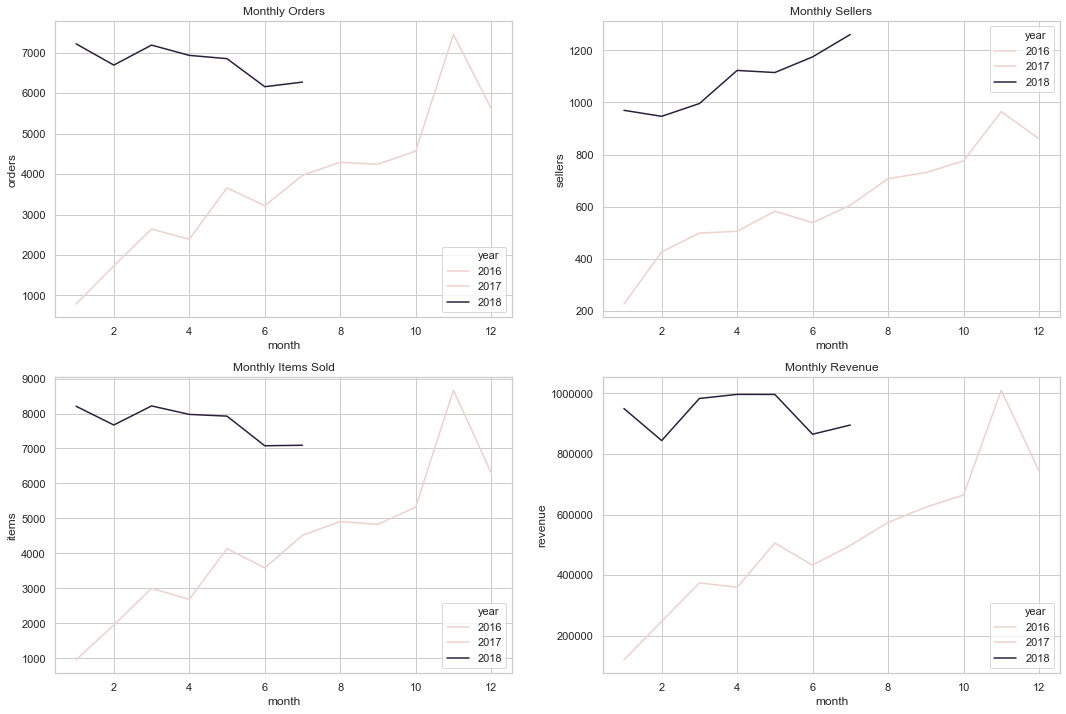

In [75]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,12))
# ax[0,0]
sns.lineplot(data=monthly_data,
             x="month",
             y="orders",
             hue="year",
             ax=ax[0,0]).set_title("Monthly Orders");

# ax[1,0]
sns.lineplot(data=monthly_data,
             x="month",
             y="items",
             hue="year",
             ax=ax[1,0]).set_title("Monthly Items Sold");

# ax[0,1]
sns.lineplot(data=monthly_data,
             x="month",
             y="sellers",
             hue="year",
             ax=ax[0,1]).set_title("Monthly Sellers");

# ax[1,1]
sns.lineplot(data=monthly_data,
             x="month",
             y="revenue",
             hue="year",
             ax=ax[1,1]).set_title("Monthly Revenue");

Plot some ratios (averages)

- avg. Items per Order
- avg. Order per Seller
- avg. Revenue per Seller

In [79]:
monthly_data = (monthly_data
                .assign(avg_items_per_order=monthly_data["items"] / monthly_data["orders"])
                .assign(avg_orders_per_seller=monthly_data["orders"] / monthly_data["sellers"])
                .assign(avg_rev_per_seller=monthly_data["revenue"] / monthly_data["sellers"]))

In [80]:
monthly_data.head()

,year,month,orders,sellers,items,revenue,avg_items_per_order,avg_orders_per_seller,avg_rev_per_seller
0,2017,1,789,227,955,120312.869803,1.210393,3.475771,530.012642
1,2017,2,1733,427,1951,247303.019816,1.125793,4.058548,579.163981
2,2017,3,2641,499,3000,374344.299496,1.135933,5.292585,750.188977
3,2017,4,2391,506,2684,359927.229713,1.122543,4.725296,711.318636
4,2017,5,3660,583,4136,506071.139302,1.130055,6.277873,868.046551


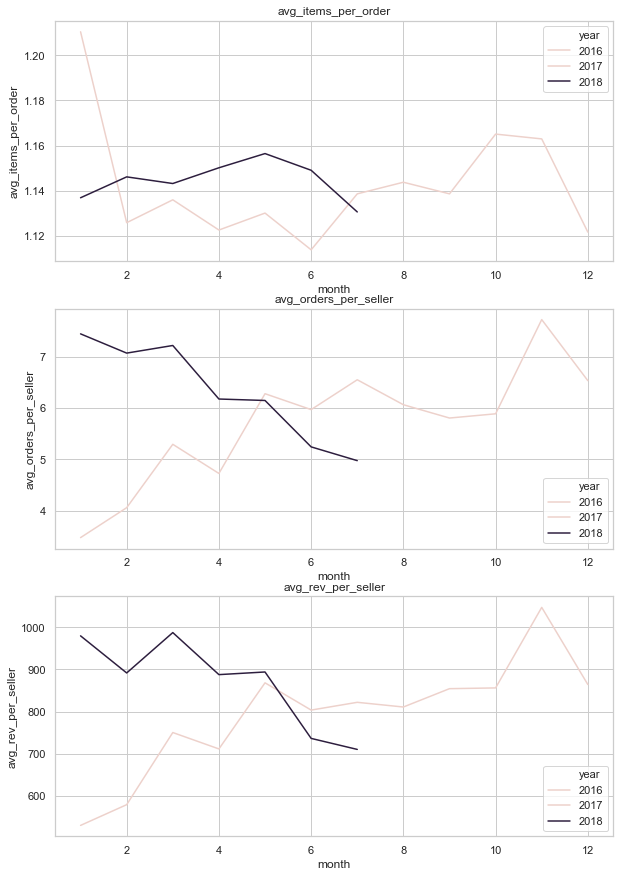

In [85]:
fig, ax = plt.subplots(3, 1, figsize=(10,15))

# instead of plotting each graph individually, we're going to loop over a list of column names
ratio_cols = ["avg_items_per_order", "avg_orders_per_seller", "avg_rev_per_seller"]

# sns.lineplot(data=monthly_data,
#              x="month",
#              y=COLUMN_NAME,
#              hue="year",
#              ax=ax[INDEX]).set_title("Monthly Orders");

for col in range(len(ratio_cols)):
    sns.lineplot(data=monthly_data,
             x="month",
             y=ratio_cols[col],
             hue="year",
             ax=ax[col]).set_title(ratio_cols[col]);

# ALTERNATIVE:
# i = 0
# for col in ratio_cols:
#     sns.lineplot(data=monthly_data,
#              x="month",
#              y=col,
#              hue="year",
#              ax=ax[i]).set_title("Monthly Orders");
#     i+=1

In [86]:
monthly_orders_by_state_query = """
SELECT
    DATE_FORMAT(o.order_purchase_timestamp, '%Y-%m-01') AS month_id,
    c.customer_state AS state,
    COUNT(o.order_id) AS orders
FROM orders o
    JOIN customers c
    ON o.customer_id = c.customer_id
WHERE o.order_purchase_timestamp < '2018-08-01'
    AND o.order_purchase_timestamp >= '2017-01-01'
GROUP BY 1,2
ORDER BY 1,2;
"""

monthly_orders_by_state = pd.read_sql(monthly_orders_by_state_query, conn)

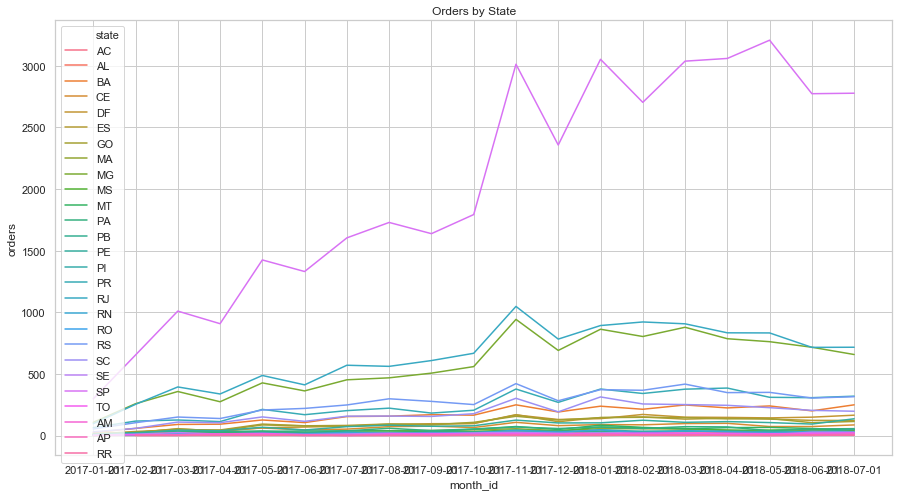

In [91]:
fig, ax = plt.subplots(figsize=(15,8))

sns.lineplot(data=monthly_orders_by_state,
             x="month_id",
             y="orders",
             hue="state",
             ax=ax).set_title("Orders by State");

That's too much, keep only the top 5 states and group the rest into one group.

In [92]:
monthly_orders_by_state.head()

,month_id,state,orders
0,2017-01-01,AC,2
1,2017-01-01,AL,2
2,2017-01-01,BA,25
3,2017-01-01,CE,9
4,2017-01-01,DF,13


In [105]:
# 1. get the top 5 states from the last month
last_month = monthly_orders_by_state["month_id"].max()
top_states = list(monthly_orders_by_state[monthly_orders_by_state["month_id"] == last_month].nlargest(5, "orders")["state"])
top_states

['SP', 'RJ', 'MG', 'PR', 'RS']

In [109]:
# 2. create a new column with grouped states
monthly_orders_by_grouped_state = (monthly_orders_by_state
                                   .assign(grouped_state=(monthly_orders_by_state["state"]
                                                          .apply(lambda x: x if x in top_states else "Other"))))

In [114]:
# 3. group by grouped_state
monthly_orders_by_grouped_state = monthly_orders_by_grouped_state.groupby(["month_id","grouped_state"]).sum().reset_index()

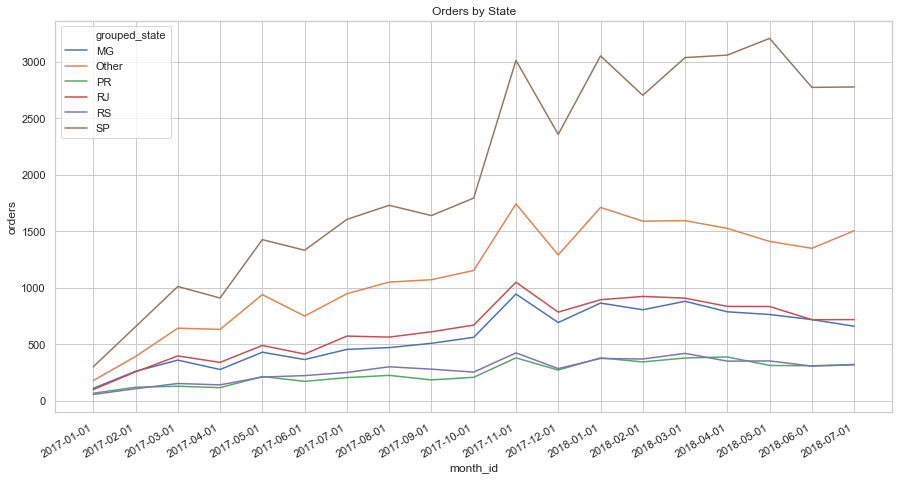

In [116]:
fig, ax = plt.subplots(figsize=(15,8))

sns.lineplot(data=monthly_orders_by_grouped_state,
             x="month_id",
             y="orders",
             hue="grouped_state",
             ax=ax).set_title("Orders by State");
fig.autofmt_xdate()

Maybe, Sao Paolo performs better than the rest of the country, because
olist is in Sao Paolo, thus shipping to other locations might take longer and customers are less satisfied.

In [118]:
review_waiting_days_query = """
SELECT
    o.customer_id,
    DATEDIFF(DATE(o.order_delivered_customer_date), DATE(o.order_purchase_timestamp)) AS waiting_days,
    r.review_score
FROM orders o
    JOIN order_reviews r
    ON o.order_id = r.order_id
WHERE o.order_status = 'delivered'
    AND o.order_purchase_timestamp < '2018-08-01'
    AND o.order_purchase_timestamp >= '2017-01-01';
"""

review_waiting_days = pd.read_sql(review_waiting_days_query, conn)

In [119]:
review_waiting_days.head()

,customer_id,waiting_days,review_score
0,9ef432eb6251297304e76186b10a928d,8.0,4
1,b0830fb4747a6c6d20dea0b8c802d7ef,14.0,4
2,f88197465ea7920adcdbec7375364d82,14.0,5
3,8ab97904e6daea8866dbdbc4fb7aad2c,3.0,5
4,503740e9ca751ccdda7ba28e9ab8f608,17.0,4


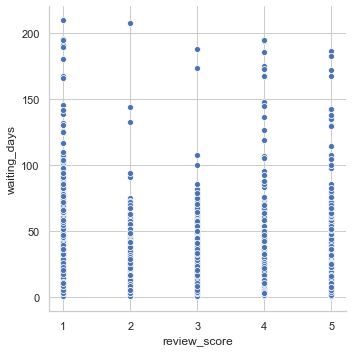

In [122]:
sns.relplot(data=review_waiting_days,
            x="review_score",
            y="waiting_days");

Not really useful. Add a fitted line

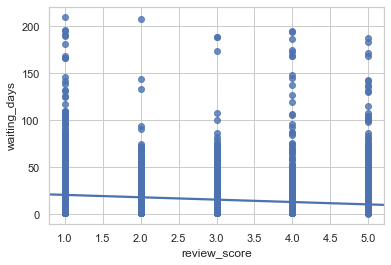

In [123]:
sns.regplot(data=review_waiting_days,
            x="review_score",
            y="waiting_days");

Or boxplots

(0, 70)

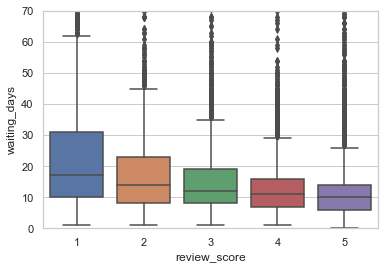

In [125]:
ax = sns.boxplot(data=review_waiting_days,
                 x="review_score",
                 y="waiting_days");
ax.set_ylim(0,70);

In [127]:
# Pearson correlation coefficient
review_waiting_days.corr()

,waiting_days,review_score
waiting_days,1.00000,-0.33988
review_score,-0.33988,1.00000


We do see, as expected, a negative linear relationship. The longer people wait for a delivery, the lower the rating tends to be